In [4]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘~p’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c gan-getting-started

 99% 364M/367M [00:04<00:00, 127MB/s]
100% 367M/367M [00:04<00:00, 79.9MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
    zip_ref.close()

## Import Libraries

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Dataset Loading

In [15]:
# Data Loading
class ImageDataset(Dataset):
    def __init__(self, photo_dir, monet_dir, transform=None):
        self.photo_images = sorted(glob.glob(os.path.join(photo_dir, '*.jpg')))
        self.monet_images = sorted(glob.glob(os.path.join(monet_dir, '*.jpg')))
        self.transform = transform

    def __len__(self):
        return len(self.photo_images)

    def __getitem__(self, idx):
        photo_img = Image.open(self.photo_images[idx]).convert('RGB')
        monet_img = Image.open(self.monet_images[idx % len(self.monet_images)]).convert('RGB')

        if self.transform:
            photo_img = self.transform(photo_img)
            monet_img = self.transform(monet_img)

        return photo_img, monet_img

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
# Create dataset
photo_ds_path = '/content/photo_jpg'
monet_ds_path = '/content/monet_jpg'
dataset = ImageDataset(photo_ds_path, monet_ds_path, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## Exploratory Data Analysis (EDA)

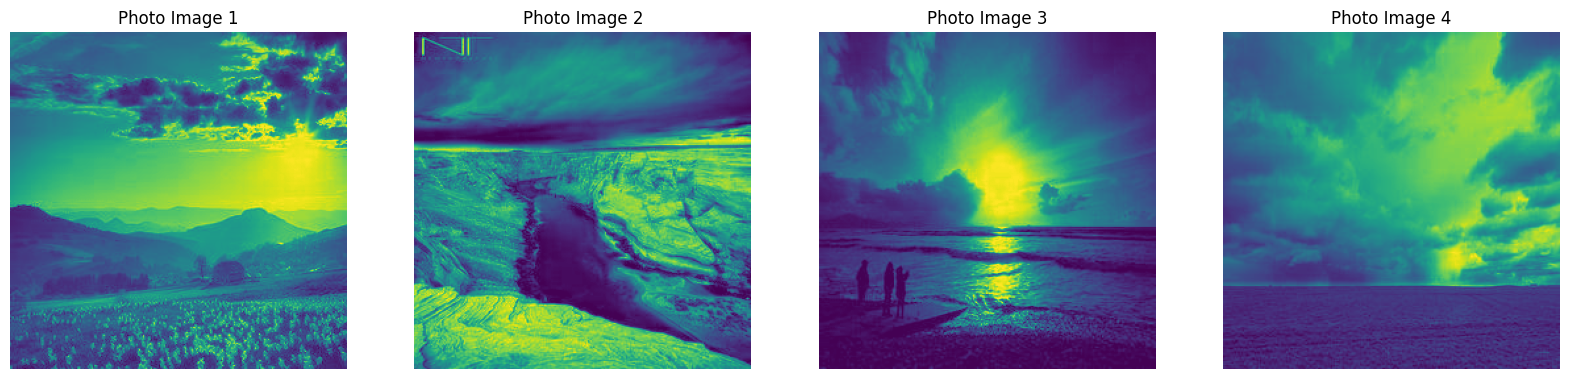

In [20]:
# Display a few images from the dataset in a single row
def show_samples(dataset, title):
    ds_iter = iter(dataset)
    plt.figure(figsize=(20, 8))  # Adjust the figure size for a single row of images
    for n_sample in range(4):
        example_sample = next(ds_iter)
        plt.subplot(1, 4, n_sample + 1)  # 1 row and 4 columns
        plt.title(f'{title} Image {n_sample + 1}')
        plt.imshow((example_sample[0][0] * 0.5) + 0.5)
        plt.axis('off')
    plt.show()

# Example usage
show_samples(dataset, 'Photo')


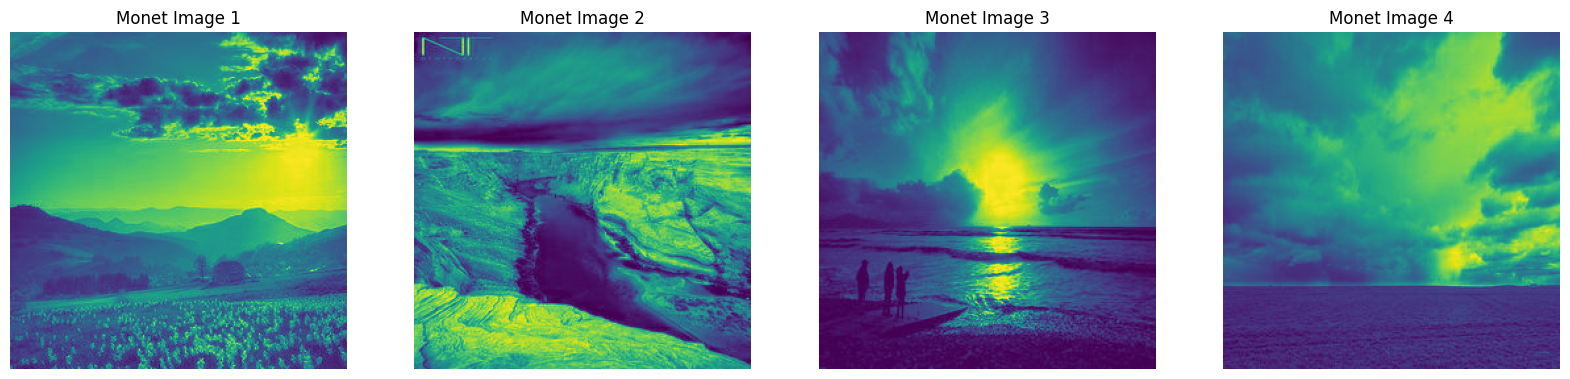

In [21]:
show_samples(dataset, 'Monet')

## Model Architecture (CycleGAN)
building the generator and discriminator models as defined earlier using downsampling and upsampling blocks.

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=1, padding=3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.main(x)

In [24]:
# Initialize Models
monet_generator = Generator().cuda()
photo_generator = Generator().cuda()
monet_discriminator = Discriminator().cuda()
photo_discriminator = Discriminator().cuda()

In [25]:
# Loss Functions and Optimizers
criterion = nn.MSELoss()
optimizer_G = torch.optim.Adam(list(monet_generator.parameters()) + list(photo_generator.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(list(monet_discriminator.parameters()) + list(photo_discriminator.parameters()), lr=2e-4, betas=(0.5, 0.999))

In [26]:
# Training Loop
def train(dataloader, epochs):
    for epoch in range(epochs):
        for real_photo, real_monet in dataloader:
            real_photo, real_monet = real_photo.cuda(), real_monet.cuda()

            # Train generators
            fake_monet = monet_generator(real_photo)
            fake_photo = photo_generator(real_monet)

            loss_G = criterion(monet_discriminator(fake_monet), torch.ones_like(monet_discriminator(fake_monet))) + \
                     criterion(photo_discriminator(fake_photo), torch.ones_like(photo_discriminator(fake_photo)))

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            # Train discriminators
            loss_D_monet = criterion(monet_discriminator(real_monet), torch.ones_like(monet_discriminator(real_monet))) + \
                           criterion(monet_discriminator(fake_monet.detach()), torch.zeros_like(monet_discriminator(fake_monet)))

            loss_D_photo = criterion(photo_discriminator(real_photo), torch.ones_like(photo_discriminator(real_photo))) + \
                           criterion(photo_discriminator(fake_photo.detach()), torch.zeros_like(photo_discriminator(fake_photo)))

            optimizer_D.zero_grad()
            (loss_D_monet + loss_D_photo).backward()
            optimizer_D.step()

        print(f"Epoch [{epoch+1}/{epochs}], loss_G: {loss_G.item()}, loss_D: {loss_D_monet.item() + loss_D_photo.item()}")

## Training model

In [28]:
# Train model
train(dataloader, epochs=5)

Epoch [1/5], loss_G: 0.8496140241622925, loss_D: 0.8309604376554489
Epoch [2/5], loss_G: 1.269255518913269, loss_D: 0.39648857712745667
Epoch [3/5], loss_G: 1.5007853507995605, loss_D: 0.199891597032547
Epoch [4/5], loss_G: 1.302162766456604, loss_D: 0.8314820937812328
Epoch [5/5], loss_G: 1.1993892192840576, loss_D: 0.3923952877521515


 ## Saving Models

In [29]:
# Save models
torch.save(monet_generator.state_dict(), "monet_generator.pth")
torch.save(photo_generator.state_dict(), "photo_generator.pth")
torch.save(monet_discriminator.state_dict(), "monet_discriminator.pth")
torch.save(photo_discriminator.state_dict(), "photo_discriminator.pth")

## Generate and Save Final Submission (images.zip)

In [33]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import glob
import shutil

# Define the Generator architecture - this should match the architecture of the saved model
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the layers of your generator here.
        # This is a placeholder architecture and needs to be replaced with the actual architecture of your saved model
        self.main = torch.nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=1, padding=3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

monet_generator = Generator().cuda()

# Load the state dictionary
monet_generator.load_state_dict(torch.load("/content/monet_generator.pth"))
monet_generator.eval()


# Data transformation for inference
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Reverse normalization for converting back to the original image format
def reverse_normalize(tensor):
    return (tensor * 0.5 + 0.5) * 255

# Directory paths
photo_ds_path = '/content/photo_jpg'  # Path to the test photos
submission_dir = './submission_images'  # Folder where generated Monet images will be stored
os.makedirs(submission_dir, exist_ok=True)

# Load test photos
photo_files = sorted(glob.glob(os.path.join(photo_ds_path, '*.jpg')))
total_images = len(photo_files)

# Ensure at least 7k-10k images are generated
target_image_count = min(10000, max(7000, total_images))

# Generate and save Monet-style images in batches
batch_size = 16  # Adjust based on your GPU memory
for batch_start in range(0, target_image_count, batch_size):
    batch_files = photo_files[batch_start:batch_start + batch_size]

    input_batch = []
    for photo_file in batch_files:
        img = Image.open(photo_file).convert('RGB')
        input_img = transform(img)
        input_batch.append(input_img)

    input_batch = torch.stack(input_batch).cuda()  # Stack into a batch and move to GPU

    with torch.no_grad():
        generated_batch = monet_generator(input_batch)

    generated_batch = generated_batch.cpu()  # Move back to CPU for saving

    for i, generated_img in enumerate(generated_batch):
        # Reverse normalization and convert to image format
        img_np = reverse_normalize(generated_img).byte().numpy().transpose(1, 2, 0)
        output_img = Image.fromarray(img_np)
        output_img.save(os.path.join(submission_dir, f"{batch_start + i + 1}.jpg"))

    print(f"Processed batch {batch_start // batch_size + 1} / {(target_image_count + batch_size - 1) // batch_size}")

# Zip the submission folder
shutil.make_archive('submission', 'zip', submission_dir)

print(f"Submission file 'submission.zip' created with generated Monet-style images.")

<ipython-input-33-2fbf460e002d>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  monet_generator.load_state_dict(torch.load("/content/monet_generator.pth"))


Processed batch 1 / 440
Processed batch 2 / 440
Processed batch 3 / 440
Processed batch 4 / 440
Processed batch 5 / 440
Processed batch 6 / 440
Processed batch 7 / 440
Processed batch 8 / 440
Processed batch 9 / 440
Processed batch 10 / 440
Processed batch 11 / 440
Processed batch 12 / 440
Processed batch 13 / 440
Processed batch 14 / 440
Processed batch 15 / 440
Processed batch 16 / 440
Processed batch 17 / 440
Processed batch 18 / 440
Processed batch 19 / 440
Processed batch 20 / 440
Processed batch 21 / 440
Processed batch 22 / 440
Processed batch 23 / 440
Processed batch 24 / 440
Processed batch 25 / 440
Processed batch 26 / 440
Processed batch 27 / 440
Processed batch 28 / 440
Processed batch 29 / 440
Processed batch 30 / 440
Processed batch 31 / 440
Processed batch 32 / 440
Processed batch 33 / 440
Processed batch 34 / 440
Processed batch 35 / 440
Processed batch 36 / 440
Processed batch 37 / 440
Processed batch 38 / 440
Processed batch 39 / 440
Processed batch 40 / 440
Processed